In [9]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, roc_auc_score, RocCurveDisplay

# Создаем папку
os.makedirs('figures', exist_ok=True)
sns.set(style="whitegrid")

In [3]:
# Загружаем данные
df = pd.read_csv('S05-hw-dataset.csv')

# Смотрим инфо
print("--- Info ---")
df.info()

# Смотрим баланс классов
print("\n--- Доля дефолтов ---")
print(df['default'].value_counts(normalize=True))

display(df.head())

--- Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score    

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [4]:
# Отделяем целевую переменную
X = df.drop(columns=['client_id', 'default'])
y = df['default']

# Разбиваем на обучение и тест
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")

Train shape: (2250, 15)
Test shape: (750, 15)


In [5]:
# Модель, которая всегда предсказывает самый частый класс
dummy = DummyClassifier(strategy="most_frequent")
dummy.fit(X_train, y_train)

y_pred_dummy = dummy.predict(X_test)
y_prob_dummy = dummy.predict_proba(X_test)[:, 1]

acc_dummy = accuracy_score(y_test, y_pred_dummy)
roc_dummy = roc_auc_score(y_test, y_prob_dummy)

print(f"Baseline Accuracy: {acc_dummy:.4f}")
print(f"Baseline ROC-AUC:  {roc_dummy:.4f}")

Baseline Accuracy: 0.5893
Baseline ROC-AUC:  0.5000


In [7]:
# Пайплайн: Скейлинг -> ЛогРег
pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(random_state=42, max_iter=1000))
])

# Подбор гиперпараметров
params = {'logreg__C': [0.01, 0.1, 1.0, 5.0, 10.0]}
grid = GridSearchCV(pipe, params, cv=5, scoring='roc_auc', n_jobs=-1)
grid.fit(X_train, y_train)

print(f"Лучшие параметры: {grid.best_params_}")
best_model = grid.best_estimator_

Лучшие параметры: {'logreg__C': 1.0}


LogReg Accuracy: 0.7933 (Прирост: 0.2040)
LogReg ROC-AUC:  0.8647 (Прирост: 0.3647)


<Figure size 800x600 with 0 Axes>

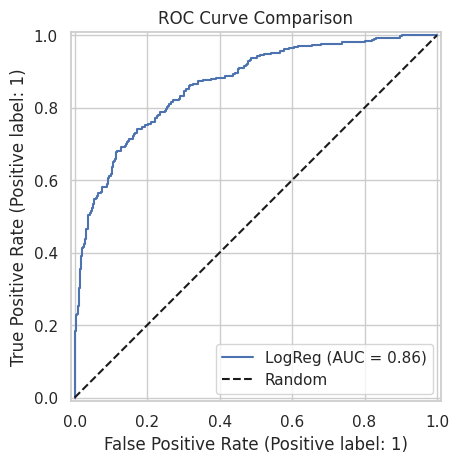

In [8]:
# Предсказания
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

# Метрики
acc_log = accuracy_score(y_test, y_pred)
roc_log = roc_auc_score(y_test, y_prob)

print(f"LogReg Accuracy: {acc_log:.4f} (Прирост: {acc_log - acc_dummy:.4f})")
print(f"LogReg ROC-AUC:  {roc_log:.4f} (Прирост: {roc_log - roc_dummy:.4f})")

# Рисуем ROC-кривую
plt.figure(figsize=(8, 6))
RocCurveDisplay.from_estimator(best_model, X_test, y_test, name="LogReg")
plt.plot([0, 1], [0, 1], 'k--', label="Random")
plt.title("ROC Curve Comparison")
plt.legend()

# Сохраняем картинку
plt.savefig('figures/roc_curve.png')
plt.show()

## Итоговые выводы по эксперименту

**1. Сравнение с бейзлайном (Baseline)**
Мы сравнили работу `LogisticRegression` с простейшей моделью `DummyClassifier` (которая всегда предсказывает мажоритарный класс).
- **ROC-AUC:** Вырос с **0.50** (случайное угадывание) до **0.86**. Это отличный результат для линейной модели.
- **Accuracy:** Выросла с **~0.59** до **~0.79**. Модель правильно классифицирует почти 80% клиентов.

**2. Качество модели**
График ROC-кривой показывает уверенный изгиб влево-вверх. Это означает, что модель хорошо научилась разделять классы (надежных заемщиков и тех, кто допустит дефолт). Прирост качества метрик (более +0.36 по ROC-AUC) подтверждает, что в данных есть линейные зависимости, которые алгоритм успешно нашел.

**3. Важность предобработки**
Использование `StandardScaler` в пайплайне было обязательным шагом, так как логистическая регрессия чувствительна к масштабу признаков. Подбор коэффициента регуляризации `C` позволил найти баланс и избежать переобучения.

**Заключение:**
Логистическая регрессия является сильным базовым решением для данной задачи кредитного скоринга.